In [34]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go

# from sklearn.preprocessing import PowerTransformer

In [35]:
lemis = pd.read_csv("lemis_imports_exports.csv")

In [36]:
lemis.head()

Unnamed: 0 species_code    genus  species          sub_species  \
0           0         AAA?  ASTRAEA  SPECIES  unknown_sub_species   
1           1         AAA?  ASTRAEA  SPECIES  unknown_sub_species   
2           2         AAA?  ASTRAEA  SPECIES  unknown_sub_species   
3           3         AAA?  ASTRAEA  SPECIES  unknown_sub_species   
4           4         AAA?  ASTRAEA  SPECIES  unknown_sub_species   

           specific_name generic_name disposition_date shipment_date  \
0  unknown_specific_name        SHELL       2005-01-13    2005-01-05   
1  unknown_specific_name        SHELL       2005-01-18    2005-01-18   
2  unknown_specific_name        SHELL       2005-01-26    2005-01-12   
3  unknown_specific_name        SHELL       2005-01-26    2005-01-17   
4  unknown_specific_name        SHELL       2005-02-15    2005-02-15   

  import_export  ... grams kilograms liters meters milligrams milliliters  \
0             I  ...   NaN       NaN    NaN    NaN        NaN         NaN   
1             E  ...   NaN       NaN    NaN    NaN        NaN         NaN   
2             I  ...   NaN       NaN    NaN    NaN        NaN         NaN   
3             I  ...   NaN       NaN    NaN    NaN        NaN         NaN   
4             E  ...   NaN       NaN    NaN    NaN        NaN         NaN   

  number_of_specimens square_centimeter square_meters unknown_unit_value  
0              1157.0               NaN           NaN                NaN  
1                 NaN               NaN           NaN                NaN  
2                 NaN               NaN           NaN                NaN  
3                 NaN               NaN           NaN                NaN  
4                 NaN               NaN           NaN                NaN  

[5 rows x 33 columns]

In [37]:
lemis.shape

(5569636, 33)

In [41]:
lemis['genus'].value_counts()[:20]

PINCTADA              380647
unknown_genus         274317
TROPICAL FISH         240280
NONCITES ENTRY        135648
ALLIGATOR             120486
CERVUS                107456
MUSTELA                97270
PYTHON                 95652
ACROPORA               91098
ODOCOILEUS             81592
OTHER LIVE INVERTS     81512
STRUTHIO               77980
VULPES                 73982
HALIOTIS               66668
ELAPHE                 61558
TRAGELAPHUS            59542
TROCHUS                56427
NEOVISON               53924
EUPHYLLIA              44553
CAIMAN                 42617
Name: genus, dtype: int64

In [42]:
sub_lemis = lemis[lemis['genus']=='PYTHON']

In [43]:
count = sub_lemis[['country_origin_value', 'country_import_export_value']].value_counts().reset_index().rename(columns={0: 'count'})
number_of_specimens = sub_lemis.groupby(['country_origin_value', 'country_import_export_value']).agg({'number_of_specimens': 'sum'}).reset_index()
number_of_specimens['number_of_specimens'] = number_of_specimens['number_of_specimens']+1

count = count.set_index(['country_origin_value', 'country_import_export_value'])
number_of_specimens = number_of_specimens.set_index(['country_origin_value', 'country_import_export_value'])
# number_of_specimens = number_of_specimens[~(number_of_specimens['country_origin_value']=='unknown_country_origin_value') & ~(number_of_specimens['country_origin_value']=='unknown_country_import_export_value')]
network_df = count.join(number_of_specimens, how='left').reset_index()

In [44]:
network_df['log_count'] = np.log(network_df['count'])
network_df['log_number_of_specimens'] = np.log(network_df['number_of_specimens'])

# power_ct = PowerTransformer()
# power_ns = PowerTransformer()

# network_df['power_count'] = power_ct.fit_transform(network_df['count'].values.reshape(1, -1))
# network_df['power_number_of_specimens'] = power_ns.fit_transform(network_df['number_of_specimens'].values.reshape(1, -1))

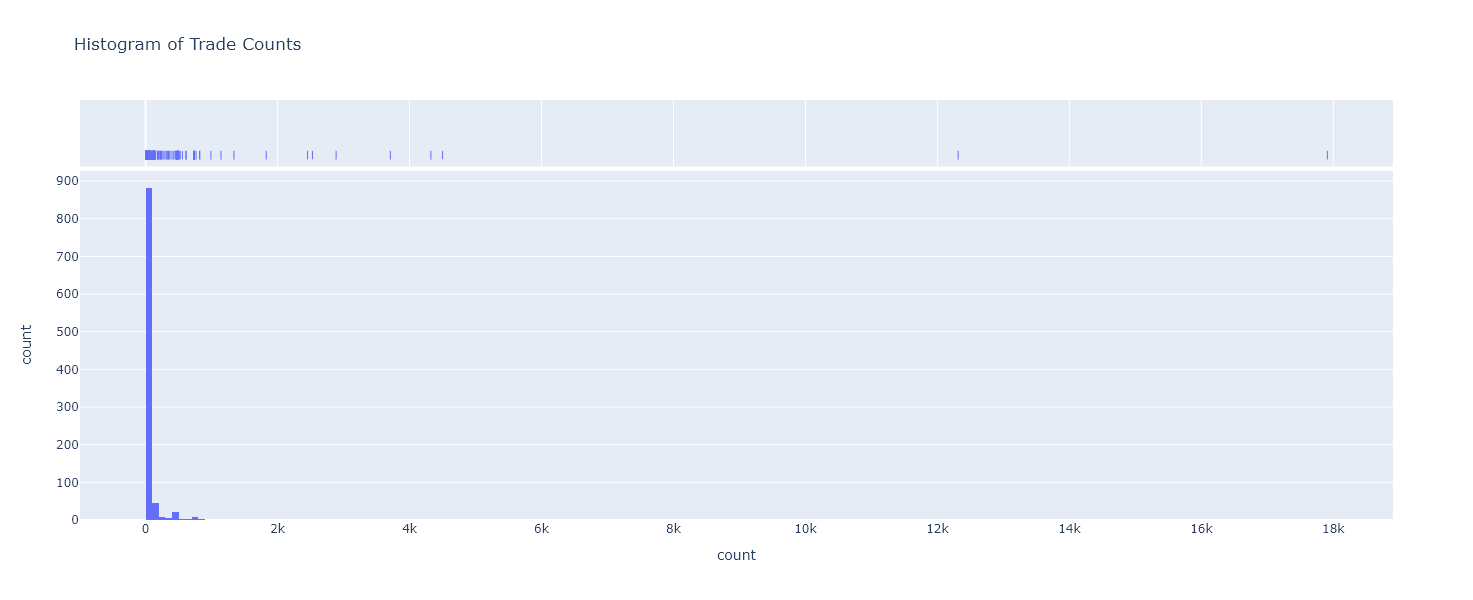

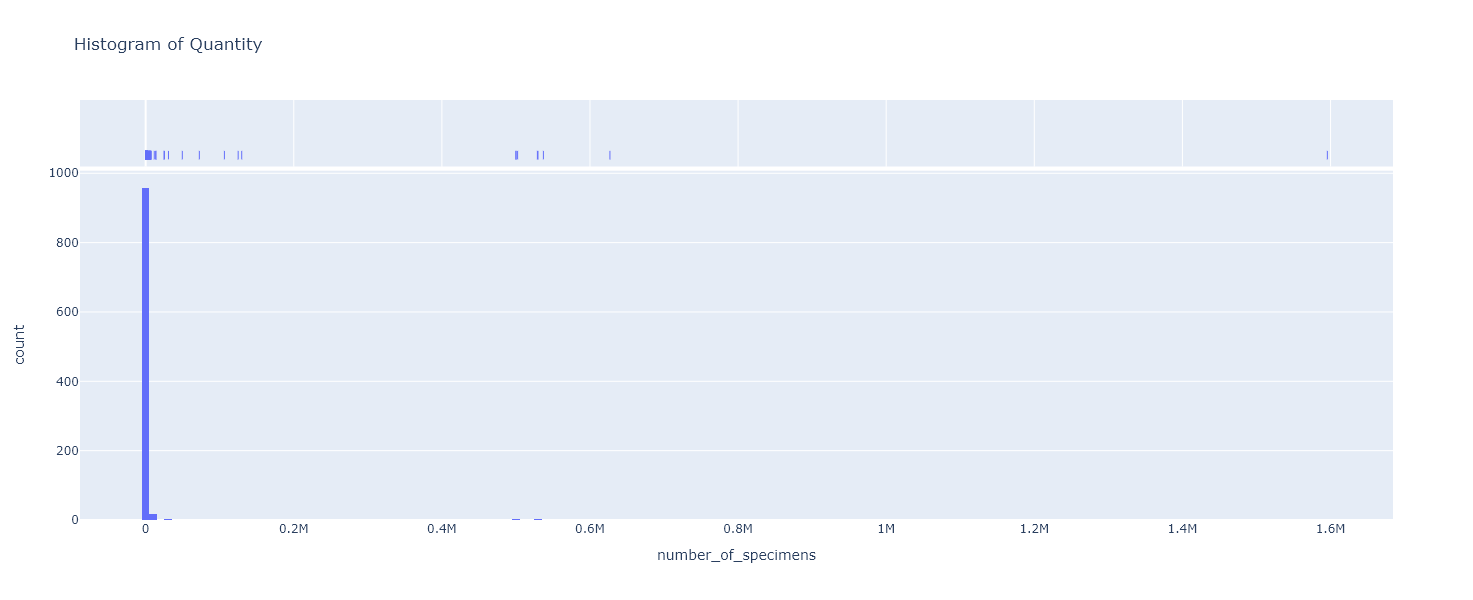

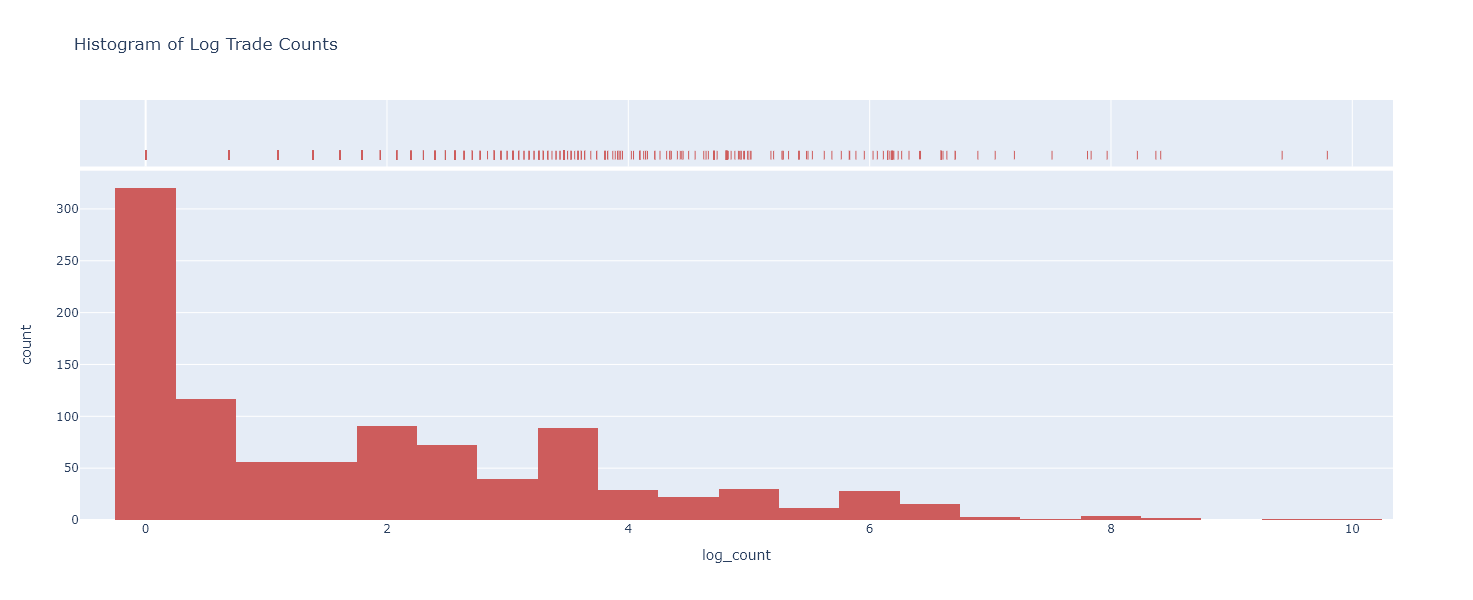

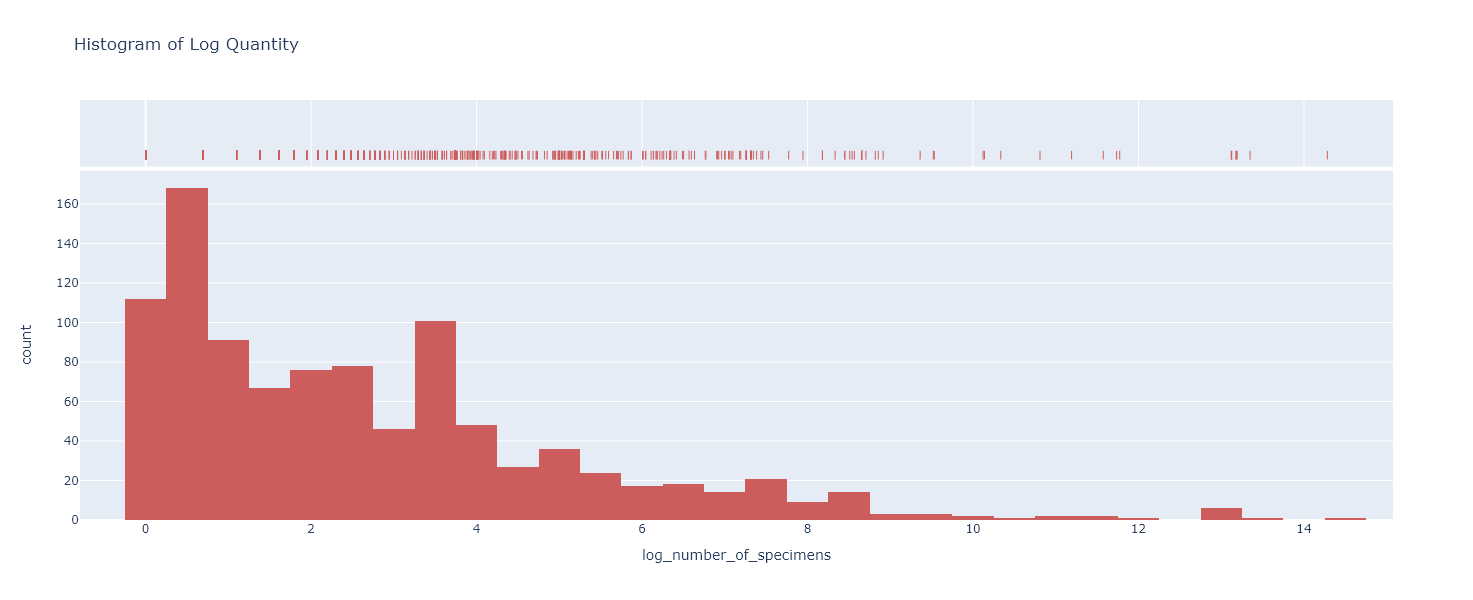

In [45]:
fig = px.histogram(network_df, x="count", marginal="rug", title='Histogram of Trade Counts', height=600)
fig.show()

fig = px.histogram(network_df, x="number_of_specimens", marginal="rug", title='Histogram of Quantity', height=600)
fig.show()

fig = px.histogram(network_df, x="log_count", marginal="rug", color_discrete_sequence=['indianred'], title='Histogram of Log Trade Counts', height=600)
fig.show()

fig = px.histogram(network_df, x="log_number_of_specimens", marginal="rug", color_discrete_sequence=['indianred'], title='Histogram of Log Quantity', height=600)
fig.show()

In [46]:
# network_df.groupby('country_origin_value')[['country_import_export_value', 'transport_mode', 'count', 'number_of_specimens']].apply(lambda x: x.set_index(['country_import_export_value', 'transport_mode']).to_dict(orient='index')).to_dict()

In [47]:
network_dict = network_df.groupby('country_origin_value')[['country_import_export_value', 'count', 'number_of_specimens']].apply(lambda x: x.set_index('country_import_export_value').to_dict(orient='index')).to_dict()
G=nx.Graph(network_dict)

In [48]:
d = dict(G.degree)
for n in G.nodes():
    G.nodes[n]['name'] = n
    G.nodes[n]['degree'] = d[n]

In [49]:
count_mean = np.mean([G[u][v]['count'] for u,v in G.edges()])
count_std = np.std([G[u][v]['count'] for u,v in G.edges()])
number_specimens_mean = np.mean([G[u][v]['number_of_specimens'] for u,v in G.edges()])
number_specimens_std = np.std([G[u][v]['number_of_specimens'] for u,v in G.edges()])

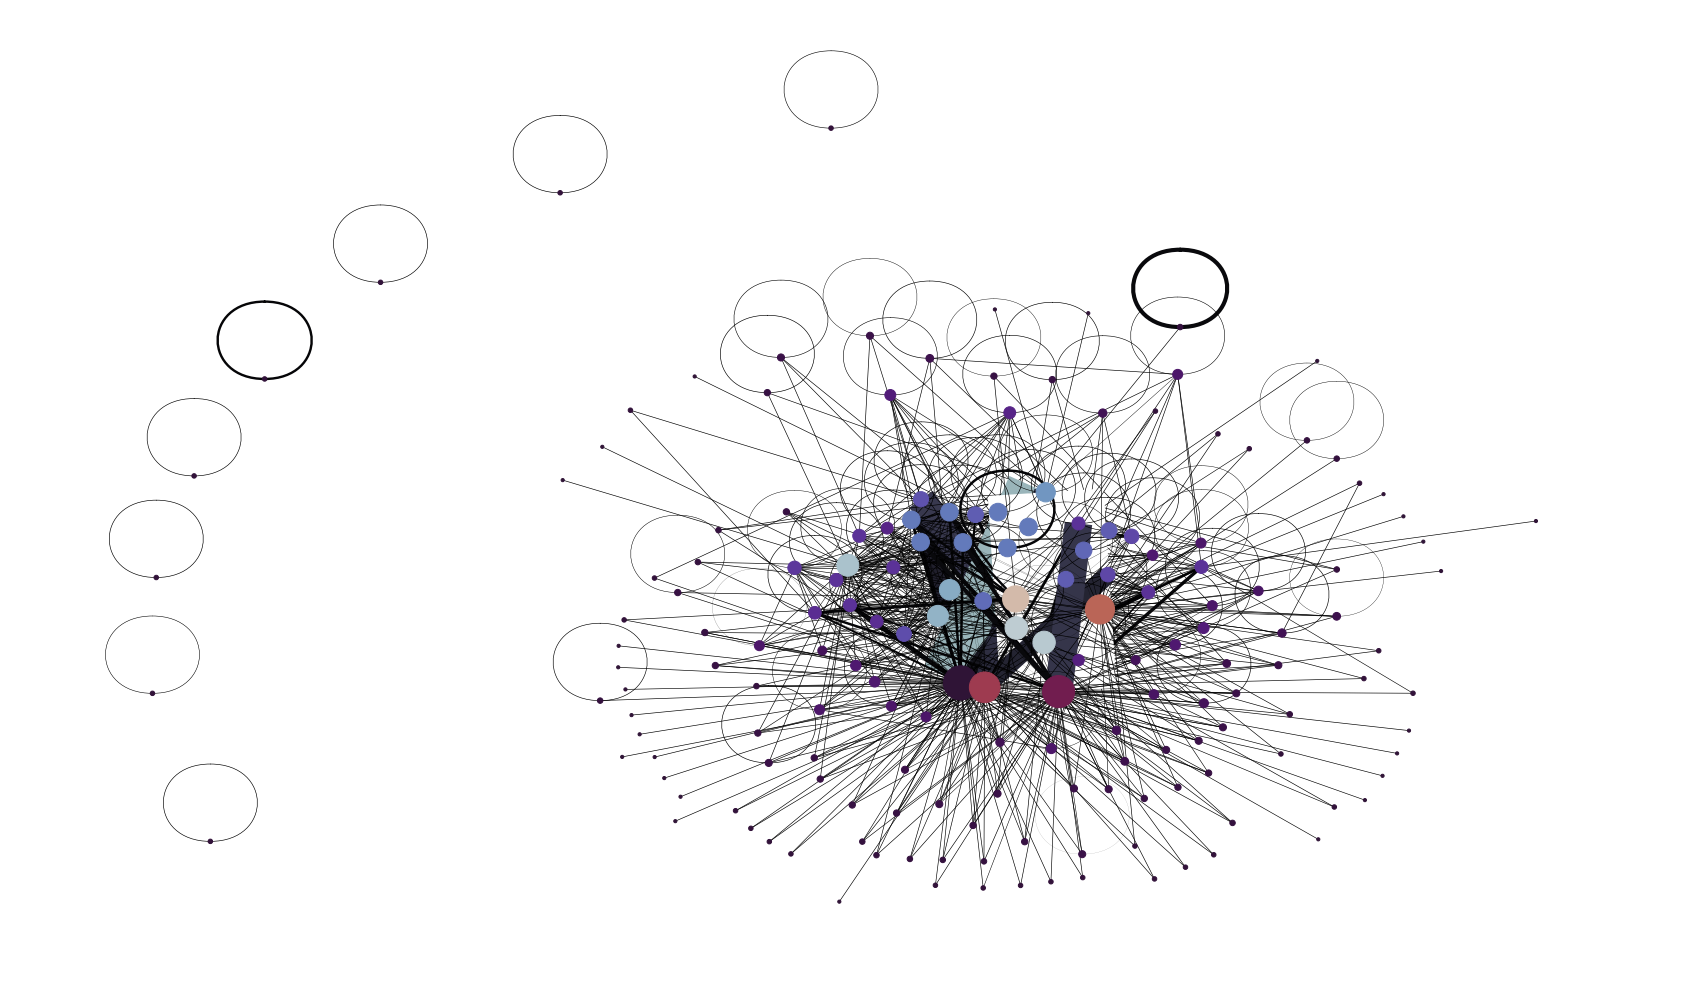

In [50]:
df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
for row, data in nx.shortest_path_length(G):
    for col, dist in data.items():
        df.loc[row,col] = dist

df = df.fillna(df.max().max())
pos = nx.kamada_kawai_layout(G, dim=2, dist=df.to_dict())

low, *_, high = sorted(d.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.twilight_shifted)

plt.figure(figsize =(30, 18))
# nx.draw(G, 
#         pos=pos,
#         nodelist=[n for n,d in d.items()],
#         node_size=[d*10 for d in d.values()],
#         node_color=[mapper.to_rgba(i) for i in d.values()],
#         with_labels=True)
n = nx.draw_networkx_nodes(G, 
                           pos, 
                           nodelist=[n for n,d in d.items()],
                           node_size=[d*10 for d in d.values()],
                           node_color=[mapper.to_rgba(i) for i in d.values()])

edge_options = {"edge_cmap": plt.cm.bone,
                "arrowstyle": "->",
                "arrowsize": 10}
e = nx.draw_networkx_edges(G,
                           pos,
                           edgelist=[(u,v) for u, v in G.edges()],
                           width=[((G[u][v]['count']-count_mean)/count_std)*5 for u,v in G.edges()],
                           edge_color=[((G[u][v]['count']-count_mean)/count_std)*5 for u,v in G.edges()],
                           **edge_options)
plt.axis('off')
plt.show()

In [51]:
def GetGraphMetrics(graph):
    
    graph_degree = dict(graph.degree)
    print(f"Number of nodes : {len(graph.nodes)}")
    print(f"Number of edges : {len(graph.edges)}")
    print(f"Transitivity : {nx.transitivity(graph)}")
    print(f"Average Clustering Coefficient : {nx.average_clustering(graph)}")
    print(f"Maximum degree : {np.max(list(graph_degree.values()))}")
    print(f"Minimum degree : {np.min(list(graph_degree.values()))}")
    print(f"Average degree : {np.mean(list(graph_degree.values()))}")
    print(f"Median degree : {np.median(list(graph_degree.values()))}")
    
    return None

In [52]:
GetGraphMetrics(G)

Number of nodes : 173
Number of edges : 951
Transitivity : 0.27101390262346575
Average Clustering Coefficient : 0.5849805276876128
Maximum degree : 117
Minimum degree : 1
Average degree : 10.99421965317919
Median degree : 4.0


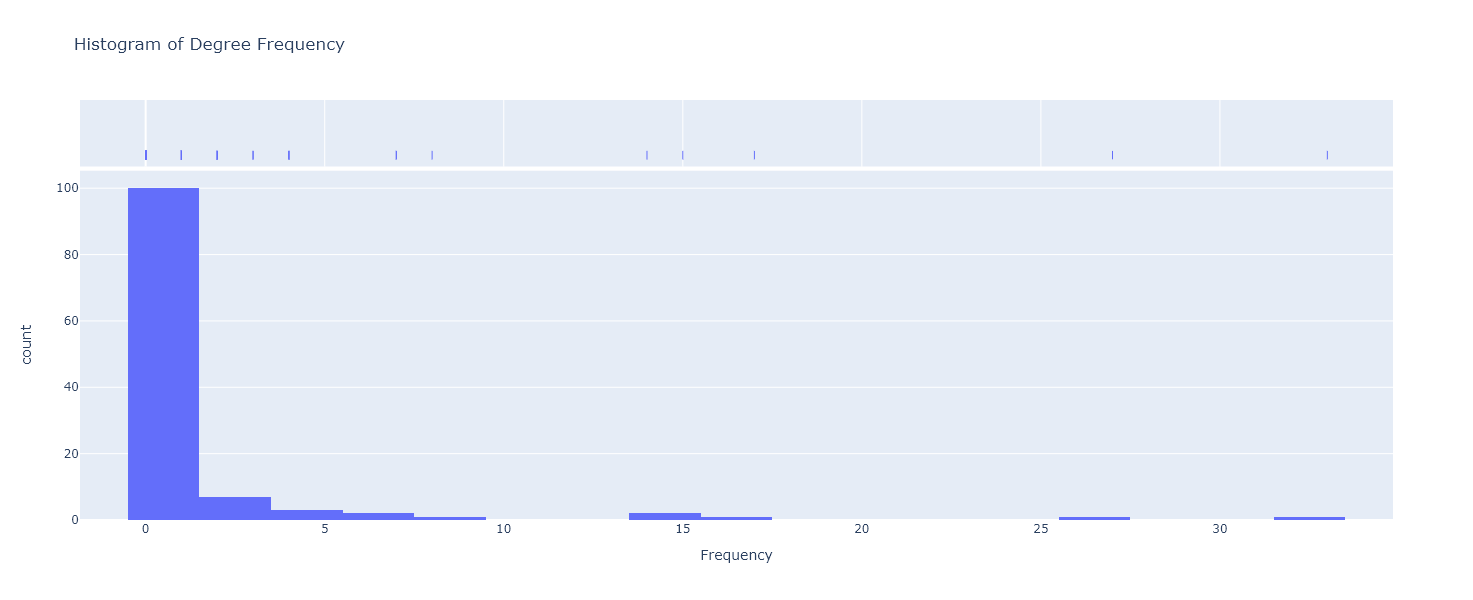

In [53]:
degree_freq = np.array(nx.degree_histogram(G)).astype('float')
degree_freq = pd.DataFrame(degree_freq, columns=['Frequency'])

# fig, ax = plt.subplots(figsize=(12, 8))
# plt.rcParams.update({'font.size': 12})

# ax = sns.histplot(degree_freq, stat='frequency')
# ax.set(ylabel="Frequency", xlabel="Degree")
# plt.show()

fig = px.histogram(degree_freq, x="Frequency", marginal="rug", title='Histogram of Degree Frequency', height=600)
fig.show()

In [54]:
def CreateDataFrameForCentralityMeasures(sorted_centrality_teams, centrality_name):
    df = pd.DataFrame(sorted_centrality_teams, columns=['Country', centrality_name])
    return df

metric_main_df = pd.DataFrame(index=list(d.keys()))

In [55]:
degree_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Degree Centrality')
closeness_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.closeness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Closeness Centrality')
betweenness_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.betweenness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Betweenness Centrality')
eigenvector_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.eigenvector_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Eigenvector Centrality')
pagerank_df = CreateDataFrameForCentralityMeasures(sorted(nx.pagerank(G).items(), key=lambda x:x[1], reverse=True), 'PageRank')
hub, auth = nx.hits(G)
hubs_df = CreateDataFrameForCentralityMeasures(sorted(hub.items(), key=lambda x:x[1], reverse=True), 'Hubs')
authorities_df = CreateDataFrameForCentralityMeasures(sorted(auth.items(), key=lambda x:x[1], reverse=True), 'Authorities')

for metric in [degree_centrality_df, closeness_centrality_df, betweenness_centrality_df, eigenvector_centrality_df, pagerank_df, hubs_df, authorities_df]:
    metric = metric.set_index('Country')
    metric_main_df = metric_main_df.join(metric)

In [56]:
metric_main_df

Degree Centrality  Closeness Centrality  \
Argentina                        0.075581              0.478202   
Ascension Island (G1*)           0.180233              0.514382   
Australia                        0.058140              0.466782   
Austria                          0.069767              0.475295   
Belgium                          0.098837              0.494848   
...                                   ...                   ...   
Saint Bathelemy                  0.005814              0.398908   
Liechtenstein                    0.005814              0.398908   
Tunisia                          0.005814              0.398908   
Greenland                        0.005814              0.398908   
Lithuania                        0.005814              0.398908   

                        Betweenness Centrality  Eigenvector Centrality  \
Argentina                             0.000298                0.068773   
Ascension Island (G1*)                0.001958                0.159102   
Australia                             0.002659                0.055096   
Austria                               0.000045                0.070606   
Belgium                               0.007581                0.087732   
...                                        ...                     ...   
Saint Bathelemy                       0.000000                0.008442   
Liechtenstein                         0.000000                0.008442   
Tunisia                               0.000000                0.008442   
Greenland                             0.000000                0.008442   
Lithuania                             0.000000                0.008442   

                        PageRank      Hubs  Authorities  
Argentina               0.005893  0.007876     0.007876  
Ascension Island (G1*)  0.012337  0.018220     0.018220  
Australia               0.004975  0.006309     0.006309  
Austria                 0.005414  0.008086     0.008086  
Belgium                 0.008250  0.010047     0.010047  
...                          ...       ...          ...  
Saint Bathelemy         0.001324  0.000967     0.000967  
Liechtenstein           0.001324  0.000967     0.000967  
Tunisia                 0.001324  0.000967     0.000967  
Greenland               0.001324  0.000967     0.000967  
Lithuania               0.001324  0.000967     0.000967  

[173 rows x 7 columns]

In [57]:
def CreateDataFrameForCentralityMeasures(dataframe, centrality_measure):

    data = dataframe.sort_values(by=centrality_measure, ascending=True)[centrality_measure].reset_index().rename(columns={'index': 'Country'})
    data = data[data[centrality_measure]>0]
    
    fig = px.bar(data[-15:], x=centrality_measure, y='Country',
                 color=centrality_measure,
                 color_continuous_scale=px.colors.sequential.Inferno,
                 height=600, width=1200)
    
    fig.show()

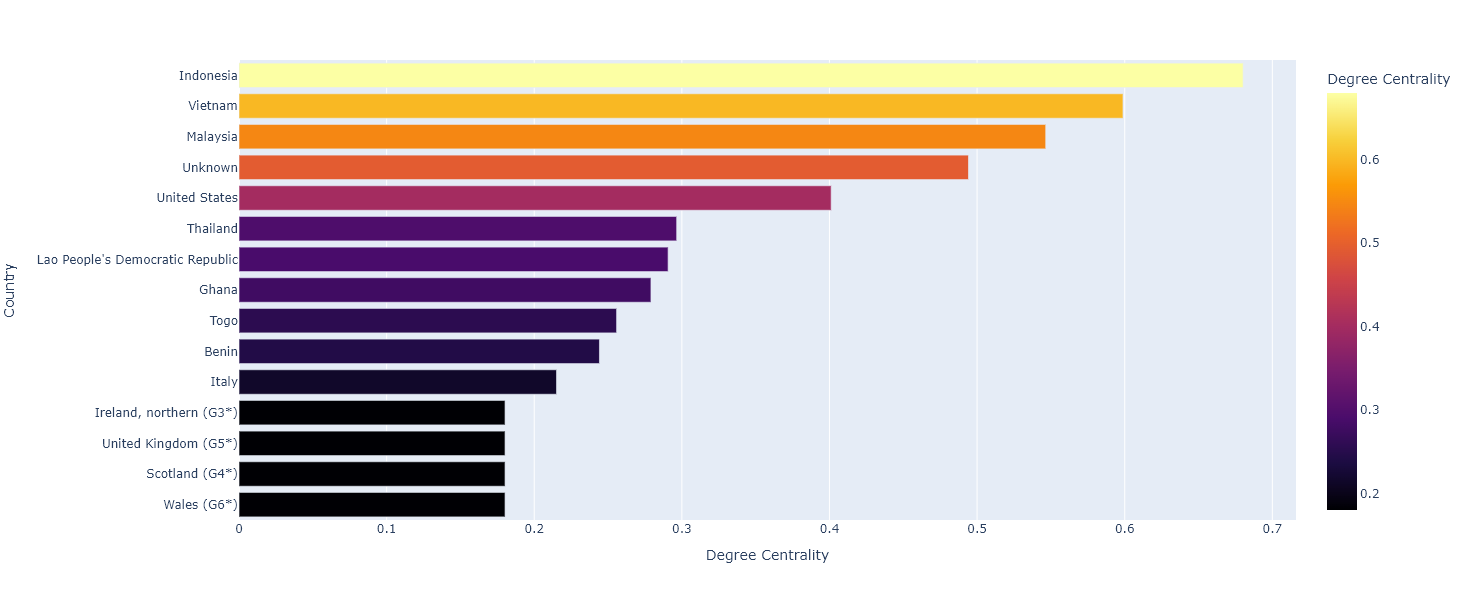

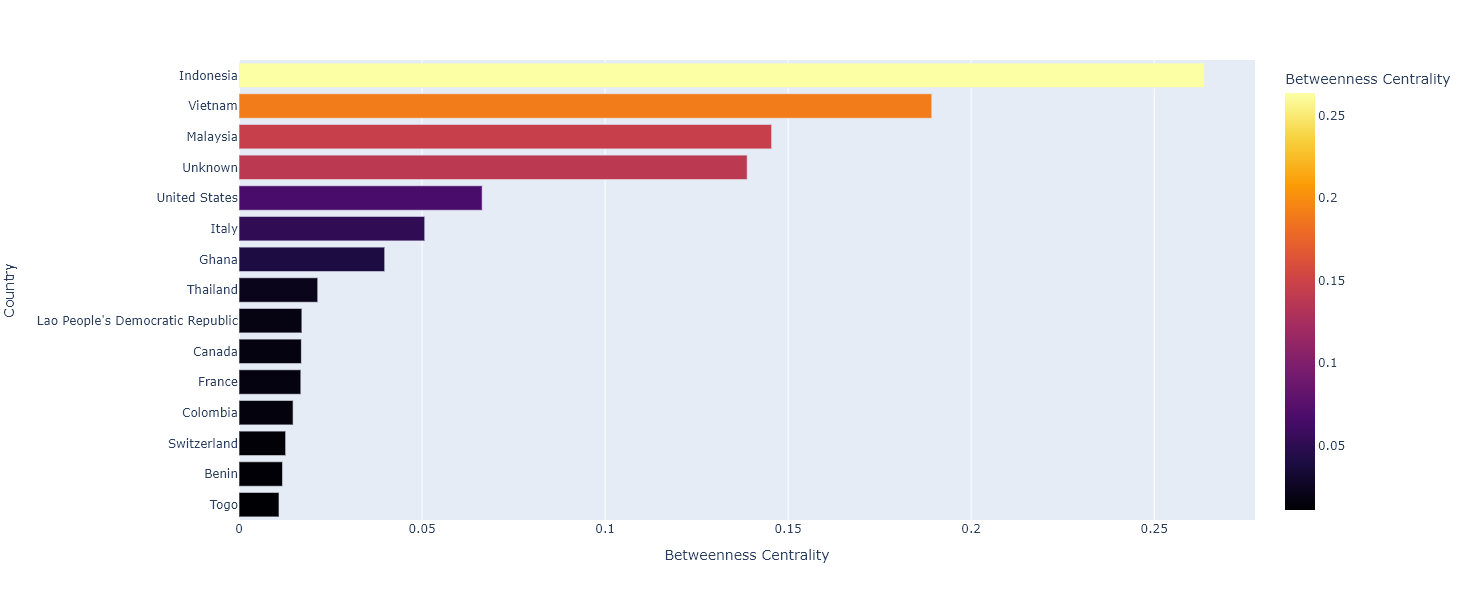

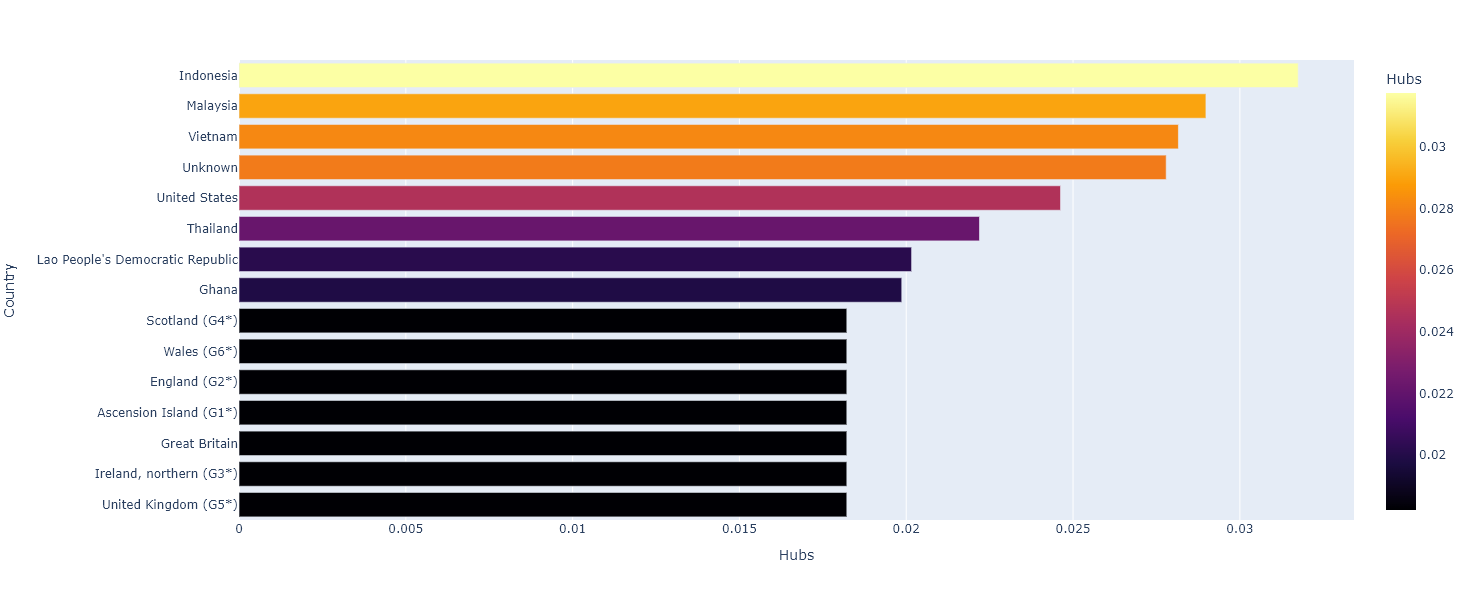

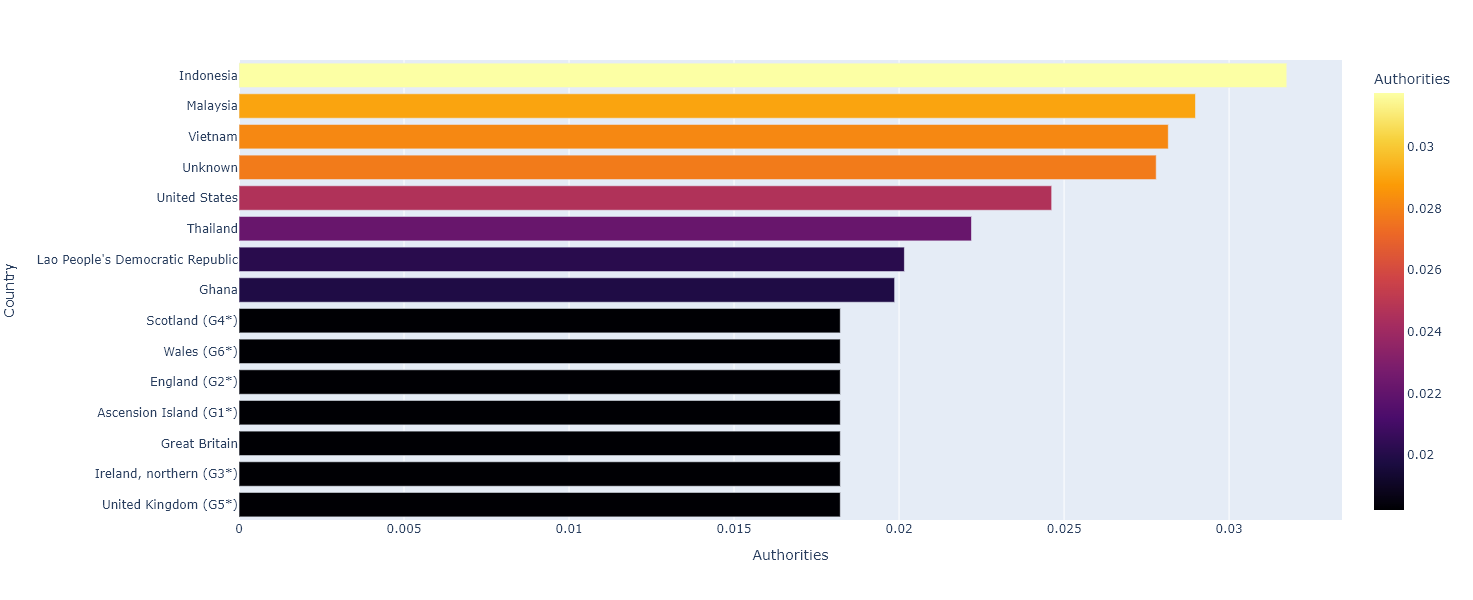

In [58]:
for centrality in ['Degree Centrality', 'Betweenness Centrality', 'Hubs', 'Authorities']:
    CreateDataFrameForCentralityMeasures(metric_main_df, centrality)

In [59]:
for n in G.nodes():
    G.nodes[n]['degree_centrality'] = metric_main_df[metric_main_df.index==n]['Degree Centrality'].values[0]
    G.nodes[n]['closeness_centrality'] = metric_main_df[metric_main_df.index==n]['Closeness Centrality'].values[0]
    G.nodes[n]['betweenness_centrality'] = metric_main_df[metric_main_df.index==n]['Betweenness Centrality'].values[0]
    G.nodes[n]['eigenvector_centrality'] = metric_main_df[metric_main_df.index==n]['Eigenvector Centrality'].values[0]
    G.nodes[n]['pagerank'] = metric_main_df[metric_main_df.index==n]['PageRank'].values[0]
    G.nodes[n]['hubs'] = metric_main_df[metric_main_df.index==n]['Hubs'].values[0]
    G.nodes[n]['authorities'] = metric_main_df[metric_main_df.index==n]['Authorities'].values[0]
    
for e in G.edges():
    G.edges[(e[0],e[1])]['jac'] = [p for u,v,p in nx.jaccard_coefficient(G, [(e[0], e[1])])][0]
    G.edges[(e[0],e[1])]['rai'] = [p for u,v,p in nx.resource_allocation_index(G, [(e[0], e[1])])][0]
    try:
        G.edges[(e[0],e[1])]['ada'] = [p for u,v,p in nx.adamic_adar_index(G, [(e[0], e[1])])][0]
    except:
        print("Adamic Adar Index didn't work, must have lots of self-loops")
    G.edges[(e[0],e[1])]['pa'] = [p for u,v,p in nx.preferential_attachment(G, [(e[0], e[1])])][0]

Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops
Adamic Adar Index didn't work, must have lots of self-loops


In [60]:
nodes = np.sort(list(set(list(G.nodes()))))
nodes_idx = {n:i-1 for i,n in enumerate(nodes)}

In [65]:
sub_lemis.transport_mode_value.unique()

array(['Air cargo', 'Personal accompanying baggage',
       'unknown_transport_mode_value', 'Mail', 'Personal vehicle',
       'Truck (or other commercial vehicle)', 'Border crossing on foot',
       'Rail'], dtype=object)

In [61]:
sub_lemis['action_disp'] = np.where(sub_lemis['action_value'] == 'Refused', sub_lemis['disposition_value'], sub_lemis['action_value'])
action_disp = list(sub_lemis.action_disp.unique())
sub_lemis.action_disp.unique()

C:\Users\anima\AppData\Local\Temp/ipykernel_17572/825194766.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['Cleared', 'Seized', 'Reexport', 'Abandoned'], dtype=object)

In [62]:
actiondisp_colors = ['rgb(23, 190, 207)', 'rgb(214, 39, 40)', 'rgb(255, 127, 14)', 'rgb(148, 103, 189)']

actiondisp_colormap = {t:c for t,c in zip(action_disp, actiondisp_colors)}

In [75]:
sankey_df = sub_lemis.groupby(['country_origin_value', 'country_import_export_value', 'action_disp', 'transport_mode_value']).agg({'number_of_specimens': 'sum'}).reset_index()
sankey_df['country_origin_value'] = sankey_df['country_origin_value'].map(nodes_idx)
sankey_df['country_import_export_value'] = sankey_df['country_import_export_value'].map(nodes_idx)
sankey_df['actiondisp_color'] = sankey_df['action_disp'].map(actiondisp_colormap)

In [76]:
sankey_df.head()

country_origin_value  country_import_export_value action_disp  \
0                     2                            2      Seized   
1                     2                           18    Reexport   
2                     2                          100     Cleared   
3                     5                            5   Abandoned   
4                     5                            5     Cleared   

                  transport_mode_value  number_of_specimens  \
0                            Air cargo                  0.0   
1                            Air cargo                  1.0   
2  Truck (or other commercial vehicle)                  0.0   
3                            Air cargo                  0.0   
4                            Air cargo                 36.0   

     actiondisp_color  
0    rgb(214, 39, 40)  
1   rgb(255, 127, 14)  
2   rgb(23, 190, 207)  
3  rgb(148, 103, 189)  
4   rgb(23, 190, 207)

In [80]:
layout =  dict(
    title = "Movement of Wildlife Trade through Countries",
    height = 1800,
    font = dict(size = 10),
)

def GenSankey(df):

    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = nodes,
          color = "#262C46"
        ),
        link = dict(
            source = df.country_origin_value,
            target = df.country_import_export_value,
            value = df.number_of_specimens,
            color = df.actiondisp_color
      )
    )], layout=layout)
                      
    return fig

buttons = []
buttons.append({'method': 'animate',
                'label': 'All',
                'args': [GenSankey(sankey_df)]
               })

for transport_mode_val in sankey_df.transport_mode_value.unique():
    buttons.append({'method': 'animate',
                    'label': transport_mode,
                    'args': [GenSankey(sankey_df[sankey_df['transport_mode_value']==transport_mode_val])]
                   })
    
updatemenu=[]
menu=dict()
updatemenu.append(menu)
updatemenu[0]['buttons']=buttons
updatemenu[0]['direction']='down'
updatemenu[0]['showactive']=True
updatemenu[0]['x']=0.9
updatemenu[0]['xanchor']='left'
updatemenu[0]['y']=1.12
updatemenu[0]['yanchor']='top'

annotations=[{'text':'Transport Mode', 
              'x':0.89, 
              'xref':'paper', 
              'y':1.12, 
              'yref':'paper',
              'align':'left', 
              'showarrow':False}]

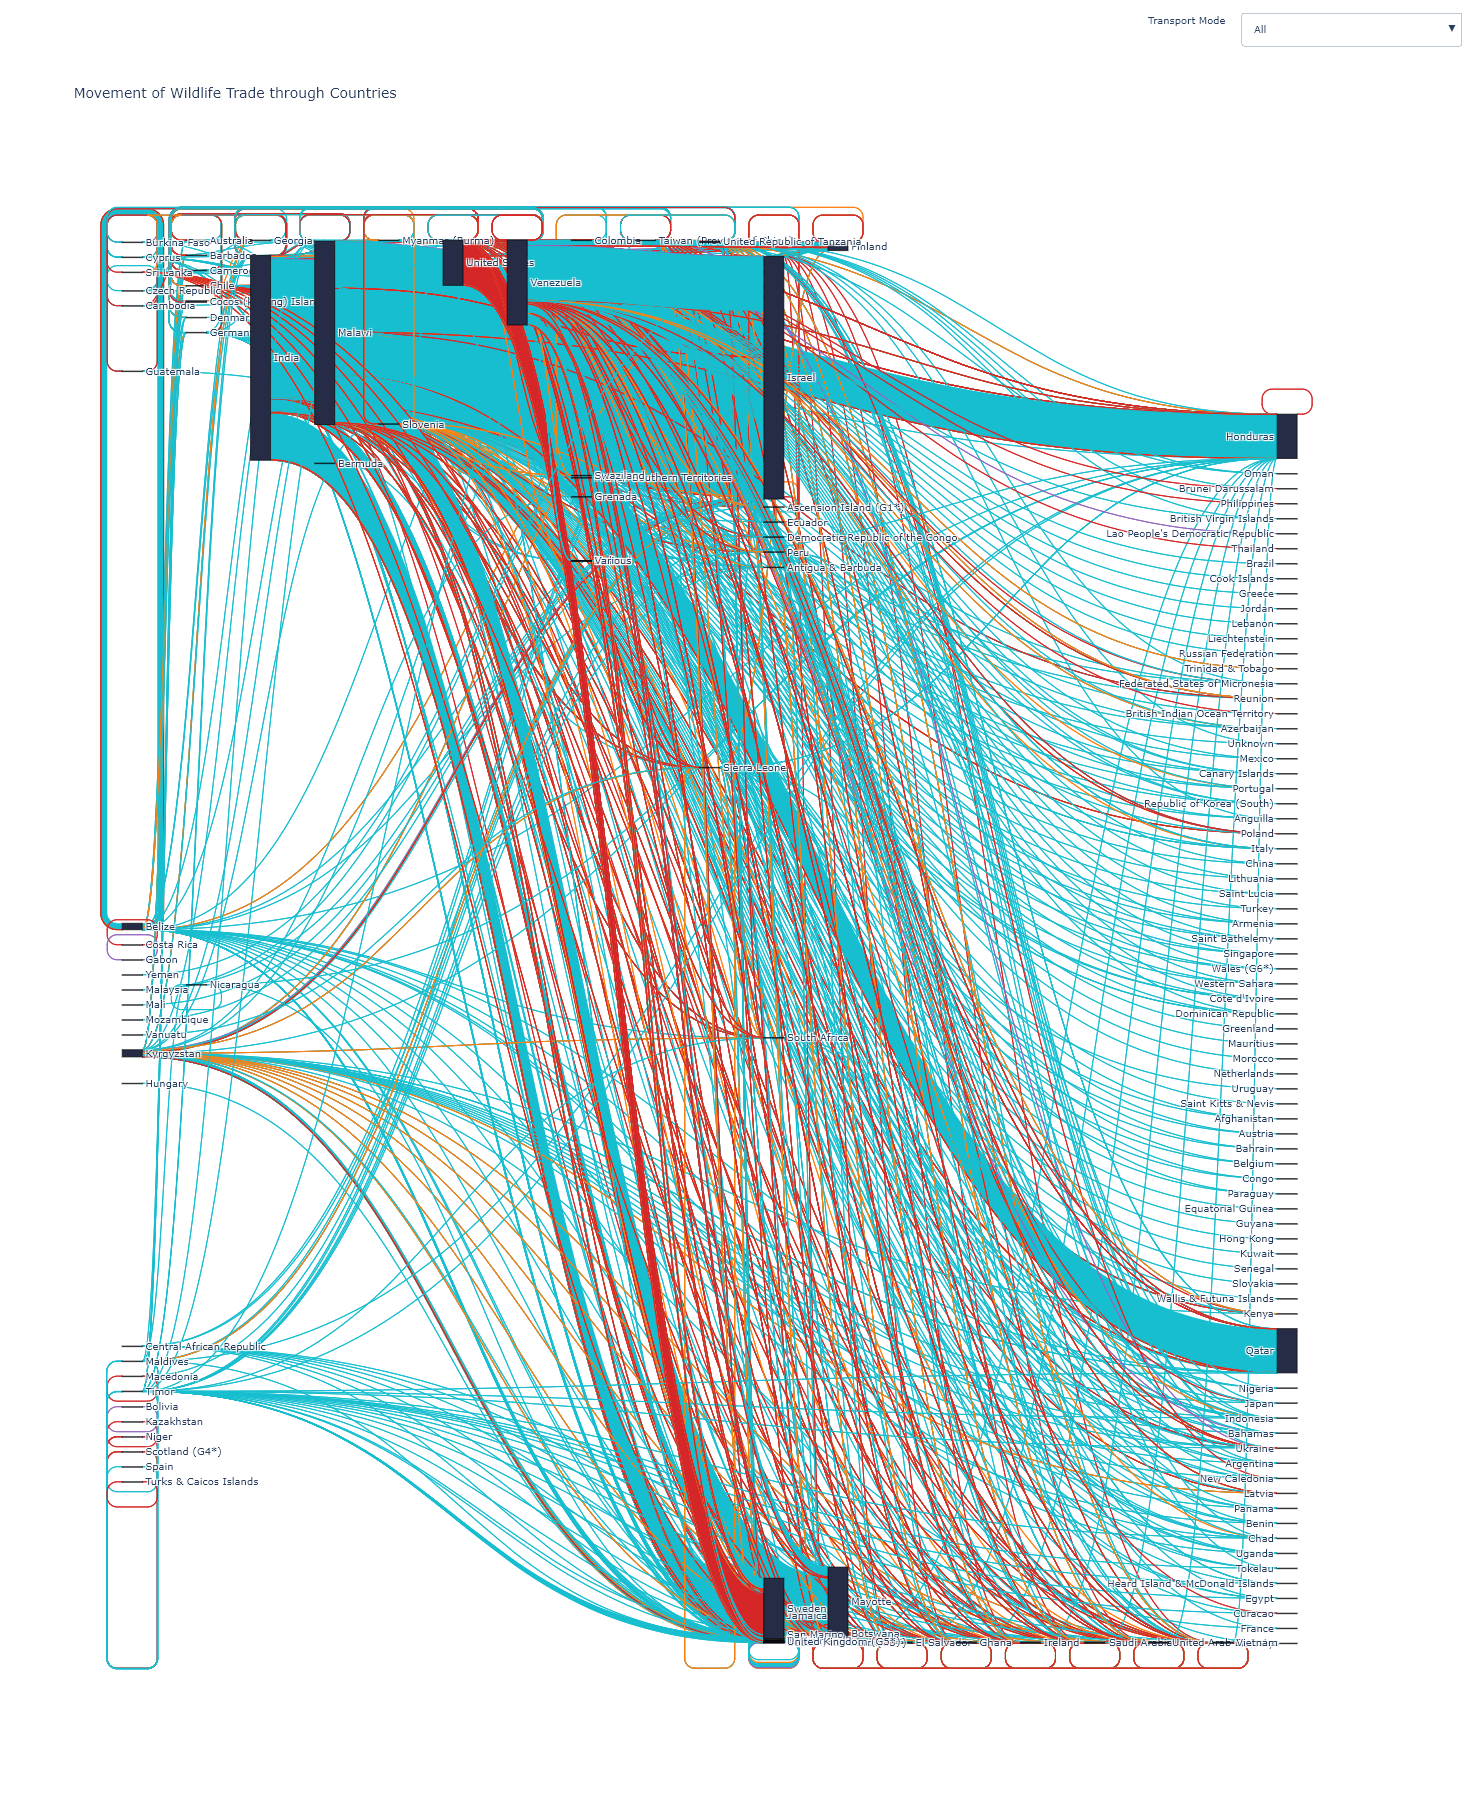

In [81]:
sankey = GenSankey(sankey_df)
fig = go.Figure(sankey)
fig.update_layout(updatemenus=updatemenu)
fig.update_layout(annotations=annotations)
fig.show()